# 26. Notion MCP 활용으로 영상 요약 내용 저장하기

## 프로젝트 개요

이 노트북은 YouTube 영상 파일에서 음성을 추출하고, OpenAI Whisper를 사용하여 텍스트로 변환한 후, 마크다운 형태의 구조적인 요약을 생성하여 Notion 데이터베이스에 자동으로 업로드하는 고급 시스템을 구축합니다.

## 1. 환경 설정

필요한 환경 변수를 로드합니다. OpenAI API 키와 Notion API 키가 `.env` 파일에 설정되어 있어야 합니다.


In [2]:
# 환경 변수 로드 - OpenAI API 키와 Notion API 키를 .env 파일에서 불러옵니다
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv()

True

## 2. 워크플로우 상태 정의

LangGraph에서 사용할 상태 구조를 정의합니다. 이 상태는 전체 워크플로우에서 데이터가 어떻게 흘러가는지 관리하며, 26번 노트북에서 `page_id` 필드가 추가되었습니다.


In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

# 워크플로우에서 사용할 상태 구조 정의
class AgentState(TypedDict):
    file_path: str      # 처리할 영상 파일 경로
    transcript: str     # Whisper로 추출한 텍스트
    outline: str        # 생성된 마크다운 아웃라인
    title: str          # 영상/문서 제목
    database_id: str    # Notion 데이터베이스 ID
    page_id: str        # 생성된 Notion 페이지 ID (2단계 업로드를 위해 추가)
    
# 상태 그래프 빌더 초기화
graph_builder = StateGraph(AgentState)

## 3. AI 모델 초기화

OpenAI의 ChatGPT와 Whisper 모델을 초기화합니다. 이 모델들은 각각 마크다운 아웃라인 생성과 음성-텍스트 변환에 사용됩니다.


In [4]:
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

# ChatGPT 모델 초기화 - 마크다운 아웃라인 생성에 사용
llm = ChatOpenAI(model="gpt-4o", temperature=0)  # temperature=0으로 설정하여 일관된 결과 생성

# Whisper 파서 초기화 - 음성/영상 파일에서 텍스트 추출에 사용
audio_parser = OpenAIWhisperParser()

## 4. 워크플로우 노드 함수 정의

### 4.1 트랜스크립트 추출 함수

영상 파일에서 OpenAI Whisper를 사용하여 음성을 텍스트로 변환하는 함수입니다. 26번 노트북과 동일한 구조를 가지고 있습니다.


In [5]:
from langchain_core.documents.base import Blob
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

def extract_transcript(state: AgentState) -> AgentState:
    """
    영상 파일에서 음성을 추출하여 텍스트로 변환하는 함수
    """
    # 상태에서 파일 경로 가져오기
    file_path = state["file_path"]
    
    # 파일을 Blob 객체로 변환 (Whisper가 처리할 수 있는 형태)
    audio_blob = Blob(path=file_path)
    
    # Whisper를 사용하여 음성을 텍스트로 변환
    documents = audio_parser.lazy_parse(audio_blob)
    
    # 변환된 텍스트들을 하나의 문자열로 결합
    transcript = ""
    for doc in documents:
        transcript += doc.page_content
    
    # 결과를 상태로 반환
    return {"transcript": transcript}

### 4.2 마크다운 아웃라인 생성 함수

추출된 텍스트를 바탕으로 ChatGPT를 사용하여 구조화된 마크다운 아웃라인을 생성하는 함수입니다. 26번 노트북과 달리 마크다운 형식으로 더 구조화된 결과를 생성합니다.


In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 아웃라인 생성용 모델 (더 정확한 결과를 위해 gpt-4o 사용)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def generate_outline(state: AgentState) -> AgentState:
    """
    추출된 텍스트를 바탕으로 구조화된 마크다운 아웃라인을 생성하는 함수
    """
    # 상태에서 트랜스크립트 가져오기
    transcript = state["transcript"]
    
    # 마크다운 아웃라인 생성을 위한 프롬프트 템플릿 설정
    outline_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates an outline for a transcript. 
Your outline must be in the markdown format using necessary headings and subheadings.
You can also use bullet points and numbered lists where you think necessary.
Make sure to use Korean when you generate the outline."""),
        ("user", "Generate an outline for the following transcript: {transcript}"),
    ])
    
    # 체인 구성: 프롬프트 -> LLM -> 문자열 파서
    outline_chain = outline_prompt | llm | StrOutputParser()
    
    # 마크다운 아웃라인 생성
    outline = outline_chain.invoke({"transcript": transcript})
    
    # 결과를 상태로 반환
    return {"outline": outline}

### 4.3 MCP 클라이언트 설정

Model Context Protocol (MCP)를 사용하여 Notion API와 통신하는 클라이언트를 설정합니다. 이는 26번 노트북의 직접 API 호출 방식과 다른 고급 연동 방식입니다.


In [10]:
import os
from langchain_mcp_adapters.client import MultiServerMCPClient

# 환경 변수에서 Notion API 키 가져오기
notion_api_key = os.getenv("NOTION_API_KEY")

# MCP (Model Context Protocol) 클라이언트 설정
# Notion API와 통신하기 위한 다중 서버 MCP 클라이언트 생성
mcp_client = MultiServerMCPClient({
  "notionApi": {
      "command": "npx",                                    
      "args": ["-y", "@notionhq/notion-mcp-server"],      # Notion MCP 서버 패키지 실행 (자동 설치)
      "env": {                                             # 환경 변수 설정
        "OPENAPI_MCP_HEADERS": f"{{\"Authorization\": \"Bearer {notion_api_key}\", \"Notion-Version\": \"2022-06-28\" }}"
      },
      "transport": "stdio"                                 # 표준 입출력을 통한 통신
    }  
})


### 4.4 MCP 도구 목록 가져오기

MCP 클라이언트에서 사용 가능한 도구들의 목록을 가져옵니다. 이 도구들은 나중에 ReAct 에이전트에서 사용됩니다.


In [13]:
# MCP 클라이언트에서 사용 가능한 도구 목록 가져오기 (비동기 함수)
# 이 도구들은 ReAct 에이전트가 Notion API와 상호작용하는 데 사용됩니다
tool_list = await mcp_client.get_tools()
tool_list

[StructuredTool(name='API-get-user', description='Notion | Retrieve a user', args_schema={'$defs': {}, 'type': 'object', 'properties': {'user_id': {'type': 'string', 'format': 'uuid'}}, 'required': ['user_id']}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x1056b4680>),
 StructuredTool(name='API-get-users', description='Notion | List all users', args_schema={'$defs': {}, 'type': 'object', 'properties': {'start_cursor': {'type': 'string', 'description': 'If supplied, this endpoint will return a page of results starting after the cursor provided. If not supplied, this endpoint will return the first page of results.'}, 'page_size': {'type': 'integer', 'default': 100, 'description': 'The number of items from the full list desired in the response. Maximum: 100'}}, 'required': []}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x134d63100>),
 Structu

### 4.5 ReAct 에이전트 생성

ReAct (Reasoning and Acting) 에이전트를 생성합니다. 이 에이전트는 추론과 행동을 결합하여 복잡한 작업을 수행할 수 있는 지능형 시스템입니다.


In [14]:
from langgraph.prebuilt import create_react_agent

# ReAct 에이전트 생성
# 이 에이전트는 추론(Reasoning)과 행동(Acting)을 결합하여 복잡한 작업을 수행
agent = create_react_agent(
    model=llm,                                                    # 사용할 언어 모델
    tools=tool_list,                                             # MCP에서 가져온 도구 목록
    prompt="Use the tools provided to you to answer the user's question"  # 에이전트에게 주는 기본 지시사항
)

### 4.6 스트림 처리 함수

에이전트의 실행 과정을 실시간으로 모니터링하기 위한 스트림 처리 함수입니다. 이 함수는 에이전트의 추론과 도구 호출 과정을 실시간으로 출력합니다.


In [15]:
async def process_stream(stream_generator):
    """
    에이전트의 실행 과정을 실시간으로 모니터링하고 결과를 수집하는 함수
    """
    results = []  # 모든 결과를 저장할 리스트
    try:
        # 스트림 생성기에서 청크 단위로 데이터를 비동기적으로 처리
        async for chunk in stream_generator:
            # 각 청크에서 첫 번째 키를 가져와 메시지 타입 확인
            key = list(chunk.keys())[0]
            
            if key == 'agent':
                # Agent 메시지의 내용을 가져옴. 메시지가 비어있는 경우 어떤 도구를 어떻게 호출할지 정보를 가져옴
                content = chunk['agent']['messages'][0].content if chunk['agent']['messages'][0].content != '' else chunk['agent']['messages'][0].additional_kwargs
                print(f"'agent': '{content}'")
            
            elif key == 'tools':
                # 도구 메시지의 내용을 가져옴 (도구 실행 결과)
                for tool_msg in chunk['tools']['messages']:
                    print(f"'tools': '{tool_msg.content}'")
            
            # 모든 청크를 결과 리스트에 추가
            results.append(chunk)
        return results
    except Exception as e:
        print(f"Error processing stream: {e}")
        return results

### 4.7 Notion 페이지 생성 함수

Notion 데이터베이스에 새로운 페이지를 생성하는 함수입니다. 이는 2단계 업로드 프로세스의 첫 번째 단계입니다.


In [16]:
import requests
import os

def create_notion_page(state: AgentState) -> AgentState:
    """
    Notion 데이터베이스에 새로운 페이지를 생성하는 함수 (2단계 업로드의 첫 번째 단계)
    """
    # 상태에서 필요한 정보 가져오기
    database_id = state['database_id']  # Notion 데이터베이스 ID
    title = state['title']              # 페이지 제목
    
    # 환경 변수에서 Notion API 키 가져오기
    notion_api_key = os.getenv("NOTION_API_KEY")
    
    # Notion API 요청 헤더 설정
    headers = {
        'Authorization': f'Bearer {notion_api_key}',
        'Content-Type': 'application/json',
        'Notion-Version': '2022-06-28'  # Notion API 버전 지정
    }
    
    # 새 페이지 생성을 위한 데이터 구성 (제목만 포함)
    data = {
        'parent': {'database_id': database_id},  # 부모 데이터베이스 지정
        'properties': {
            'Title': {'title': [{'text': {'content': title}}]},  # 페이지 제목 설정
        },
    }
    
    # Notion API에 페이지 생성 요청
    response = requests.post(
        'https://api.notion.com/v1/pages',
        headers=headers,
        json=data
    )
    
    # 응답 결과 출력
    print(response.json())
    
    # 생성된 페이지 ID를 상태로 반환 (두 번째 단계에서 사용)
    return {'page_id': response.json()['id']}

### 4.8 Notion 콘텐츠 업로드 함수

생성된 Notion 페이지에 마크다운 아웃라인을 구조화된 블록으로 업로드하는 함수입니다. 이는 2단계 업로드 프로세스의 두 번째 단계로, ReAct 에이전트를 활용하여 지능적으로 내용을 업로드합니다.


In [17]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate

async def upload_to_notion(state: AgentState) -> AgentState:
    """
    생성된 Notion 페이지에 마크다운 아웃라인을 구조화된 블록으로 업로드하는 함수
    ReAct 에이전트를 활용하여 지능적으로 내용을 업로드
    """
    # 상태에서 필요한 정보 가져오기
    page_id = state['page_id']    # 첫 번째 단계에서 생성된 페이지 ID
    outline = state['outline']    # 생성된 마크다운 아웃라인
    
    # 에이전트에게 전달할 메시지 템플릿 생성
    human_message_prompt = PromptTemplate.from_template("""Add block to the page of which id is {page_id}
and add the outline as children blocks to the page. 
Make sure to follow the format of the outline which is in markdown format
When you use headings, make sure to follow the format below:
{{
  //...other keys excluded
  "type": "heading_1", # heading_1, heading_2, heading_3
  //...other keys excluded
  "heading_1": {{
    "rich_text": [{{
      "type": "text",
      "text": {{
        "content": "Lacinato kale",
        "link": null
      }}
    }}],
    "color": "default",
    "is_toggleable": false
  }}
}}

The outline is as follows: 
{outline}""")
    
    # 템플릿을 사용하여 실제 메시지 생성
    human_message = human_message_prompt.format(page_id=page_id, outline=outline)
    
    # 에이전트에 메시지를 전달하고 스트림 모드로 실행
    stream_generator = agent.astream({"messages": [HumanMessage(human_message)]}, stream_mode="updates")
    
    # 스트림을 처리하여 모든 결과 수집
    all_chunks = await process_stream(stream_generator)

    # 최종 결과 출력
    if all_chunks:
        final_result = all_chunks[-1]
        print("\nFinal result:", final_result)

## 5. 워크플로우 그래프 구성

### 5.1 노드 추가

정의한 함수들을 그래프의 노드로 추가합니다. 26번 노트북과 달리 4개의 노드를 사용하여 2단계 업로드 프로세스를 구현합니다.


In [18]:
# 워크플로우 그래프에 노드 추가
graph_builder.add_node(extract_transcript)    # 트랜스크립트 추출 노드
graph_builder.add_node(generate_outline)      # 마크다운 아웃라인 생성 노드
graph_builder.add_node(create_notion_page)    # Notion 페이지 생성 노드 (1단계)
graph_builder.add_node(upload_to_notion)      # Notion 콘텐츠 업로드 노드 (2단계)

### 5.2 워크플로우 엣지 연결 및 그래프 컴파일

노드들 간의 실행 순서를 정의하고 그래프를 컴파일합니다. 26번 노트북과 달리 4단계 프로세스를 구현합니다.


In [19]:
from langgraph.graph import START, END

# 워크플로우 실행 순서 정의 (엣지 연결)
graph_builder.add_edge(START, 'extract_transcript')                          # 시작 → 트랜스크립트 추출
graph_builder.add_edge('extract_transcript', 'generate_outline')             # 트랜스크립트 추출 → 마크다운 아웃라인 생성
graph_builder.add_edge('generate_outline', 'create_notion_page')             # 아웃라인 생성 → Notion 페이지 생성
graph_builder.add_edge('create_notion_page', 'upload_to_notion')             # 페이지 생성 → 콘텐츠 업로드
graph_builder.add_edge('upload_to_notion', END)                              # 콘텐츠 업로드 → 종료

# 그래프 컴파일 (실행 가능한 상태로 변환)
graph = graph_builder.compile()

## 6. 워크플로우 시각화

구성된 워크플로우를 시각적으로 확인할 수 있습니다.


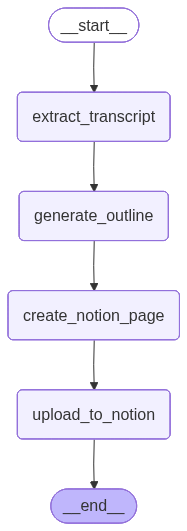

In [20]:
# 워크플로우 그래프 시각화
graph

## 7. 워크플로우 실행

실제 영상 파일을 처리하여 전체 워크플로우를 비동기적으로 실행합니다.

### 실행 파라미터
- `file_path`: 처리할 영상 파일 경로
- `database_id`: Notion 데이터베이스 ID
- `title`: 생성될 페이지 제목

### 실행 순서
1. 영상 파일에서 음성 추출 및 텍스트 변환
2. 추출된 텍스트를 바탕으로 구조화된 마크다운 아웃라인 생성
3. Notion 데이터베이스에 새로운 페이지 생성
4. ReAct 에이전트를 활용하여 마크다운 아웃라인을 구조화된 블록으로 업로드

In [21]:
# 워크플로우 비동기 실행
# 영상 파일 경로, Notion 데이터베이스 ID, 제목을 설정하여 전체 프로세스 실행
await graph.ainvoke({
    "file_path": "./videos/0_2_dimension_measure.mp4",  # 처리할 영상 파일 경로
    "database_id": "2ad02806fca5801e90efe6cf13d24c48",  # Notion 데이터베이스 ID
    "title": "Dimension과 Measure 비교"                      # 페이지 제목
})

Transcribing part 1!
{'object': 'page', 'id': '2ae02806-fca5-8129-ba71-f131bb3c98ab', 'created_time': '2025-11-17T12:31:00.000Z', 'last_edited_time': '2025-11-17T12:31:00.000Z', 'created_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'last_edited_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'cover': None, 'icon': None, 'parent': {'type': 'database_id', 'database_id': '2ad02806-fca5-801e-90ef-e6cf13d24c48'}, 'archived': False, 'in_trash': False, 'is_locked': False, 'properties': {'Title': {'id': 'title', 'type': 'title', 'title': [{'type': 'text', 'text': {'content': 'Dimension과 Measure 비교', 'link': None}, 'annotations': {'bold': False, 'italic': False, 'strikethrough': False, 'underline': False, 'code': False, 'color': 'default'}, 'plain_text': 'Dimension과 Measure 비교', 'href': None}]}}, 'url': 'https://www.notion.so/Dimension-Measure-2ae02806fca58129ba71f131bb3c98ab', 'public_url': None, 'request_id': '4b6bb9b9-635c-486c-a876-95269ae972

{'file_path': './videos/0_2_dimension_measure.mp4',
 'transcript': '그럼 태블러 시험범위 중에서 태블러의 기본 개념을 다루는 이 도메인4로 들어가겠습니다. 일단 데이터를 엑셀로 열어서 확인해 봅시다. 이 South Superstore 라는 엑셀은 아래 여러가지 탭들로 이루어져 있네요. 지금 보면 Southern Region 이라는 탭은 맨 왼쪽에 rowid라는 컬럼부터 시작해서 오더 데이트라는 날짜 형식의 컬럼도 보이고 커스텀을 네임이라던지 세그먼트와 같이 문자 형식의 데이터도 보이구요. 여기 세일즈라던지 프로핏같이 숫자 형식의 데이터도 확인할 수 있습니다. 이 데이터를 태블러로 불러올 거에요. 저희의 데이터는 엑셀 파일이기 때문에 이 마이크로소프트 엑셀을 통해서 해당 파일을 열 것입니다. 이렇게 열면 여기 데이터 소스라는 태블러 탭이 열리면서 왼쪽에는 아까 저희가 엑셀에서 봤던 탭들이 나옵니다. 그 중에서 Southern Region을 더블 클릭하면 아까 엑셀에서 보았던 rowid, order date, ship mode, customer name 까지 아까 봤던 그 컬럼이 그대로 보입니다. 이것을 확인한 후에 이제 시트원으로 이동을 해봅니다. 일단 가장 먼저 다뤄볼 것은 태블러의 dimension과 measure의 차이입니다. dimension이냐 measure이냐 적용 대상은 데이터의 컬럼입니다. 우리가 보았던 그 각각의 컬럼이 dimension 아니면 measure 둘 중에 하나에 속할 거에요. 다행히 우리가 직접 분류할 필요 없이 이미 태블러가 자동으로 분류를 해줍니다. 태블러의 데이터 영역에 보시면 중간에 가느다란 실선이 있는데 이 위쪽이 dimension, 아래쪽은 measure 라고 합니다. 그래서 이걸 통해서 바로 어떤 컬럼이 dimension인지 measure인지 알 수 있어요. 그래서 실제로 둘의 차이가 무엇이냐면 느낌적인 느낌으로 여기에 해당하는 dimension은 뭔가 숫자가 아닌 데